In [35]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import seaborn as sns
import random
import timm
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

!pip install torch efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

from transformers import BertModel, BertTokenizer
from transformers import XLNetModel, XLNetTokenizer
from transformers import BertForSequenceClassification, XLNetForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(50)

In [38]:
images_path = "/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/Images"
train_csv_path = '/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/train.xlsx'
test_csv_path = '/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/test.xlsx'

In [39]:
train_df = pd.read_excel(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [40]:
train_df

,filename,tweet,label,image
0,buildingfire_2017-02-05_04-06-10.txt,Here's some video of the smoldering ruins in W...,damaged_infrastructure,buildingfire_2017-02-05_04-06-10.JPG
1,isiscrimes_2015-08-04_00-18-33.txt,27 person were killed yesterday near idlib nor...,human_damage,isiscrimes_2015-08-04_00-18-33.JPG
2,earthquake_2017-11-13_07-23-10.txt,تصویری از خسارات زلزله در سرپل ذهاب\n#earthqua...,damaged_infrastructure,earthquake_2017-11-13_07-23-10.JPG
3,ad_2017-11-25_07-56-53.txt,Link in bio #fashion #style #dt #friends #Inst...,non_damage,ad_2017-11-25_07-56-53.JPG
4,hurricanesandy_2017-10-29_22-36-42.txt,Covering the aftermath of Hurricane #Sandy 5 y...,flood,hurricanesandy_2017-10-29_22-36-42.JPG
...,...,...,...,...
5242,cars_2017-10-30_17-48-22.txt,Tuner Evo SoCal \nOfficial Vendor/Sponsor \n@t...,non_damage,cars_2017-10-30_17-48-22.JPG
5243,buildingfire_2016-12-07_17-48-56.txt,Building fire yesterday in Boulder City #fire ...,fires,buildingfire_2016-12-07_17-48-56.JPG
5244,nature_2017-10-30_17-47-15.txt,Walking in the forest is soooooo relaxing ! \n...,non_damage,nature_2017-10-30_17-47-15.JPG
5245,ad_2017-11-25_11-07-37.txt,"a blue dream,💙 Use the code ""VANESSA35"" to get...",non_damage,ad_2017-11-25_11-07-37.JPG


In [41]:
test_df

,filename,tweet,label,image
0,ad_2017-11-25_10-36-26.txt,⭐ We are really getting into the christmas spi...,non_damage,ad_2017-11-25_10-36-26.JPG
1,building_2017-10-30_17-26-34.txt,IJOY uv board has the competetive price and ve...,non_damage,building_2017-10-30_17-26-34.JPG
2,floodwater_2017-09-04_04-46-10.txt,Arriving in Kalkundi island destroyed in #bang...,flood,floodwater_2017-09-04_04-46-10.JPG
3,accrafloods_2015-06-06_16-59-56.txt,"Hi my lovelies, check out My first hand exper...",flood,accrafloods_2015-06-06_16-59-56.JPG
4,buildingfire_2016-10-02_03-07-17.txt,The Hamilton fire service during an exercise a...,fires,buildingfire_2016-10-02_03-07-17.JPG
...,...,...,...,...
579,floodwater_2017-08-27_23-49-50.txt,#gameofthrones #naturaldisaster #naturalmote #...,flood,floodwater_2017-08-27_23-49-50.JPG
580,nature_2017-10-30_17-47-50.txt,İyi İnsanlara Çıksın Gittiğimiz Tüm Yollar 🙏🏻❤...,non_damage,nature_2017-10-30_17-47-50.JPG
581,earthquake_2017-11-13_23-23-28.txt,Pray for Iran_kermanshah🙏🙏🙏\n.\nکرمانشاهم شهر ...,damaged_infrastructure,earthquake_2017-11-13_23-23-28.JPG
582,ad_2017-11-25_08-21-38.txt,A little hand painting using @framarint brushe...,non_damage,ad_2017-11-25_08-21-38.JPG


In [42]:
train_df['tweet'][0]

"Here's some video of the smoldering ruins in White Hall, IL. When I left I smelled like a campfire. 3 massive buildings destroyed by a giant fire. A local woman told me about it all. Just unbelievably sad. So much history and such a historic loss in a really small town. #smalltownusa #whitehall #centralillinois #illinois_shots #architecture #brickstagram #firedamage #buildingruins #exploreillinois #buildingfire"

In [43]:
print(len(train_df))
print(len(test_df))

5247
584


In [44]:
trdata = {
    'image': [],
    'tweet': [],
    'label': []
}
combinedf = pd.DataFrame(trdata)

tedata = {
    'image': [],
    'tweet': [],
    'label': []
}
testdf = pd.DataFrame(tedata)

label_map = {
    "non_damage": 0,
    "damaged_infrastructure": 1,
    "damaged_nature": 2,
    "fires": 3,
    "flood": 4,
    "human_damage": 5
}

combinedf['label'] = train_df['label'].map(label_map)
testdf['label'] = test_df['label'].map(label_map)

def replace_string(row):
  return row.replace('.JPG', '.jpg')
combinedf['image'] = train_df['image'].apply(replace_string)
testdf['image'] = test_df['image'].apply(replace_string)

combinedf['tweet']= train_df['tweet']
testdf['tweet']= test_df['tweet']
# combinedf['tweet'].fillna('', inplace=True)
# testdf['tweet'].fillna('', inplace=True)

In [45]:
rows_with_empty_values = combinedf[combinedf.isna().any(axis=1)]
print(rows_with_empty_values)

                           image tweet  label
2445  ad_2017-11-25_09-14-52.jpg   NaN      0


In [46]:
combinedf = combinedf.dropna().reset_index(drop=True)

In [47]:
rows_with_empty_values = combinedf[combinedf.isna().any(axis=1)]
print(rows_with_empty_values)

Empty DataFrame
Columns: [image, tweet, label]
Index: []


In [48]:
#combinedf = shuffle(combinedf, random_state=42)
traindf=combinedf[:4663]
validdf= combinedf[4663:]

In [49]:
print(len(combinedf))
print(len(traindf))
print(len(validdf))
print(len(testdf))

5246
4663
583
584


In [50]:
# traindf['image_exist'] = traindf['image'].apply(lambda x: os.path.exists(os.path.join(images_path, x)))

In [51]:
# traindf = traindf[traindf['image_exist']]
# traindf = traindf.drop(columns=['image_exist'])

In [52]:
traindf

,image,tweet,label
0,buildingfire_2017-02-05_04-06-10.jpg,Here's some video of the smoldering ruins in W...,1
1,isiscrimes_2015-08-04_00-18-33.jpg,27 person were killed yesterday near idlib nor...,5
2,earthquake_2017-11-13_07-23-10.jpg,تصویری از خسارات زلزله در سرپل ذهاب\n#earthqua...,1
3,ad_2017-11-25_07-56-53.jpg,Link in bio #fashion #style #dt #friends #Inst...,0
4,hurricanesandy_2017-10-29_22-36-42.jpg,Covering the aftermath of Hurricane #Sandy 5 y...,4
...,...,...,...
4658,hurricaneirma_2017-11-21_19-52-42.jpg,#rebuildthekeys #thisisourhome #orcspirit #oce...,2
4659,yemencrisis_2016-02-13_02-40-54.jpg,طفل من ألف طفل قتلتهم السعودية والإمارات..\nلن...,5
4660,building_2017-10-30_17-03-48.jpg,#many #group #city #building #architecture #la...,0
4661,earthquake_2017-11-07_05-46-10.jpg,#condesa #cdmx #night #city #earthquake #sismo...,1


In [53]:
validdf

,image,tweet,label
4663,ad_2017-11-25_04-12-10.jpg,1_Loveletter Ver.\n[ Follow to the Film ]\nEpi...,0
4664,ad_2017-11-25_10-45-52.jpg,"My text: “Send me coffee”\n•\n•\nSFMOMA bot, t...",0
4665,naturaldisaster_2017-10-13_07-10-42.jpg,Back home time for some cleaning.. @ surf popo...,2
4666,wreckedcar_2017-02-12_16-59-16.jpg,#wreck #car #wreckedcar #winter #snow #honor8,1
4667,ad_2017-11-25_03-25-45.jpg,In #Utah the #onion harvest has finished. The ...,0
...,...,...,...
5241,cars_2017-10-30_17-48-22.jpg,Tuner Evo SoCal \nOfficial Vendor/Sponsor \n@t...,0
5242,buildingfire_2016-12-07_17-48-56.jpg,Building fire yesterday in Boulder City #fire ...,3
5243,nature_2017-10-30_17-47-15.jpg,Walking in the forest is soooooo relaxing ! \n...,0
5244,ad_2017-11-25_11-07-37.jpg,"a blue dream,💙 Use the code ""VANESSA35"" to get...",0


In [54]:
validdf.reset_index(drop=True, inplace=True)

In [55]:
validdf

,image,tweet,label
0,ad_2017-11-25_04-12-10.jpg,1_Loveletter Ver.\n[ Follow to the Film ]\nEpi...,0
1,ad_2017-11-25_10-45-52.jpg,"My text: “Send me coffee”\n•\n•\nSFMOMA bot, t...",0
2,naturaldisaster_2017-10-13_07-10-42.jpg,Back home time for some cleaning.. @ surf popo...,2
3,wreckedcar_2017-02-12_16-59-16.jpg,#wreck #car #wreckedcar #winter #snow #honor8,1
4,ad_2017-11-25_03-25-45.jpg,In #Utah the #onion harvest has finished. The ...,0
...,...,...,...
578,cars_2017-10-30_17-48-22.jpg,Tuner Evo SoCal \nOfficial Vendor/Sponsor \n@t...,0
579,buildingfire_2016-12-07_17-48-56.jpg,Building fire yesterday in Boulder City #fire ...,3
580,nature_2017-10-30_17-47-15.jpg,Walking in the forest is soooooo relaxing ! \n...,0
581,ad_2017-11-25_11-07-37.jpg,"a blue dream,💙 Use the code ""VANESSA35"" to get...",0


In [56]:
testdf

,image,tweet,label
0,ad_2017-11-25_10-36-26.jpg,⭐ We are really getting into the christmas spi...,0
1,building_2017-10-30_17-26-34.jpg,IJOY uv board has the competetive price and ve...,0
2,floodwater_2017-09-04_04-46-10.jpg,Arriving in Kalkundi island destroyed in #bang...,4
3,accrafloods_2015-06-06_16-59-56.jpg,"Hi my lovelies, check out My first hand exper...",4
4,buildingfire_2016-10-02_03-07-17.jpg,The Hamilton fire service during an exercise a...,3
...,...,...,...
579,floodwater_2017-08-27_23-49-50.jpg,#gameofthrones #naturaldisaster #naturalmote #...,4
580,nature_2017-10-30_17-47-50.jpg,İyi İnsanlara Çıksın Gittiğimiz Tüm Yollar 🙏🏻❤...,0
581,earthquake_2017-11-13_23-23-28.jpg,Pray for Iran_kermanshah🙏🙏🙏\n.\nکرمانشاهم شهر ...,1
582,ad_2017-11-25_08-21-38.jpg,A little hand painting using @framarint brushe...,0


In [57]:
class_counts = traindf['label'].value_counts()
print(class_counts)

0    2366
1    1114
2     406
4     300
3     274
5     203
Name: label, dtype: int64


In [58]:
class_counts = validdf['label'].value_counts()
print(class_counts)

0    299
1    132
2     53
4     48
3     35
5     16
Name: label, dtype: int64


In [59]:
class_counts = testdf['label'].value_counts()
print(class_counts)

0    291
1    144
2     55
3     37
4     36
5     21
Name: label, dtype: int64


In [60]:
transform_train = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_test = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [61]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_path, transforms=None):
        self.dataframe = dataframe
        self.images_path = images_path
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = os.path.join(self.images_path, self.dataframe.iloc[index]['image'])
        image = Image.open(img_name)
        label = self.dataframe.iloc[index]['label']

        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

In [62]:
train_dataset = CustomDataset(traindf, images_path, transforms=transform_train)
validation_dataset = CustomDataset(validdf, images_path, transforms=transform_test)
test_dataset = CustomDataset(testdf, images_path, transforms=transform_test)

In [63]:
class_counts = traindf['label'].value_counts()
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(len(class_counts))])
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device,dtype=torch.float32)

In [64]:
learning_rate = 1e-4
momentum = 0.9
beta_2 = 0.999
epsilon = 1e-8
weight_decay = 0.0
amsgrad = False

In [65]:
criterion = nn.CrossEntropyLoss()
num_classes = 6
batch_size = 12
num_iters= 30000
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

77


In [66]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader= DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [67]:
print(len(train_loader))
print(len(test_loader))
print(len(valid_loader))

389
49
49


In [68]:
def callbacks_check():
    num_classes = 6
    accuracy_threshold = 0.99

    class MyCallback:
        def __init__(self):
            self.best_accuracy = 0.0

        def on_epoch_end(self, epoch, accuracy):
            if accuracy > accuracy_threshold:
                print("\nReached {:.2f}% accuracy, so we will stop training".format(accuracy_threshold * 100))
                return True
            return False

    acc_callback = MyCallback()

    return acc_callback

In [35]:
def create_model(architecture, num_classes):
    if architecture == "resnet50":
        model = models.resnet50(pretrained=True)
        torch.nn.Sequential(*list(model.children())[:-1])
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    elif architecture == "densenet201":
        model = models.densenet201(pretrained=True)
        torch.nn.Sequential(*list(model.children())[:-1])
        num_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    elif architecture == "efficientnetb3":
        model = EfficientNet.from_pretrained('efficientnet-b3')
        torch.nn.Sequential(*list(model.children())[:-1])
        num_features = model._fc.in_features
        model._fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    return model

In [36]:
def create_models():
    num_classes = 6
    ImageModels = []

    for architecture in ["resnet50", "densenet201", "efficientnetb3"]:
        model = create_model(architecture, num_classes)
        ImageModels.append(model)

    return ImageModels

image_models = create_models()
print(image_models)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.8MB/s]
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 81.6MB/s]
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 79.9MB/s]


Loaded pretrained weights for efficientnet-b3
[ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): 

In [37]:
model_name = ["resnet50", "densenet201", "efficientnetb3"]

In [38]:
train_loss_history0 = []
train_acc_history0 = []
test_loss_history0 = []
test_acc_history0 = []

train_loss_history1 = []
train_acc_history1= []
test_loss_history1 = []
test_acc_history1 = []

train_loss_history2 = []
train_acc_history2 = []
test_loss_history2 = []
test_acc_history2 = []

In [39]:
for idx, model in enumerate(image_models):
    
    print("===============> ",model_name[idx], "<===================")

    model.to(device)
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate)

    patience = 10
    best_val_loss = float('inf')
    counter = 0


    callback_list = callbacks_check()

    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        tepoch_loss = running_loss / len(train_loader)
        tepoch_acc = correct_predictions / total_samples

        if idx==0:
            train_loss_history0.append(tepoch_loss)
            train_acc_history0.append(tepoch_acc)

        elif idx==1:
            train_loss_history1.append(tepoch_loss)
            train_acc_history1.append(tepoch_acc)

        else:
            train_loss_history2.append(tepoch_loss)
            train_acc_history2.append(tepoch_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {tepoch_loss:.4f}, Accuracy: {tepoch_acc:.4f}")

        model.eval()
        vrunning_loss = 0
        vcorrect_predictions = 0
        vtotal_samples = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                vrunning_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                vcorrect_predictions += (predicted == labels).sum().item()
                vtotal_samples += labels.size(0)
                

        epoch_loss = vrunning_loss / len(valid_loader)
        epoch_acc = vcorrect_predictions / total_samples

        if idx==0:
            test_loss_history0.append(epoch_loss)
            test_acc_history0.append(epoch_acc)

        elif idx==1:
            test_loss_history1.append(epoch_loss)
            test_acc_history1.append(epoch_acc)

        else:
            test_loss_history2.append(epoch_loss)
            test_acc_history2.append(epoch_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        if callback_list.on_epoch_end(epoch+1, tepoch_acc):
            print(print("Early stopping triggered at epoch",epoch+1))
            break

        elif (epoch_loss < best_val_loss):
            best_val_loss = epoch_loss
            counter = 0
            torch.save(model.state_dict(),'{}_best_model.pt'.format(idx))
            print("Model saved")
            model.train()

        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}.')
                break

    print("------------------------------------------------------")

print("########## Training Complete ###########")

===============>  resnet50 <===================
Epoch [1/77], Train Loss: 0.8178, Accuracy: 0.7026
Epoch [1/77], Validation Loss: 0.5970, Accuracy: 0.7736
Model saved
Epoch [2/77], Train Loss: 0.6424, Accuracy: 0.7662
Epoch [2/77], Validation Loss: 0.6148, Accuracy: 0.7873
Epoch [3/77], Train Loss: 0.5661, Accuracy: 0.8018
Epoch [3/77], Validation Loss: 0.6293, Accuracy: 0.7719
Epoch [4/77], Train Loss: 0.5156, Accuracy: 0.8139
Epoch [4/77], Validation Loss: 0.6004, Accuracy: 0.7736
Epoch [5/77], Train Loss: 0.4518, Accuracy: 0.8424
Epoch [5/77], Validation Loss: 0.5960, Accuracy: 0.8113
Model saved
Epoch [6/77], Train Loss: 0.3998, Accuracy: 0.8570
Epoch [6/77], Validation Loss: 0.6277, Accuracy: 0.8096
Epoch [7/77], Train Loss: 0.3458, Accuracy: 0.8786
Epoch [7/77], Validation Loss: 0.5633, Accuracy: 0.8096
Model saved
Epoch [8/77], Train Loss: 0.3264, Accuracy: 0.8818
Epoch [8/77], Validation Loss: 0.7129, Accuracy: 0.7839
Epoch [9/77], Train Loss: 0.3064, Accuracy: 0.8908
Epoch [9/

In [40]:
Maxlist=[max(test_acc_history0),max(test_acc_history1), max(test_acc_history2)]
bm=Maxlist.index(max(Maxlist))
bm

2

In [41]:
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

In [42]:
if bm==0:

    model.load_state_dict(torch.load('0_best_model.pt'))
    print("Resnet50 Model Loaded")

    train_acc_history= train_acc_history0
    test_acc_history= test_acc_history0

    train_loss_history= train_loss_history0
    test_loss_history= test_loss_history0

elif bm==1:

    model.load_state_dict(torch.load('1_best_model.pt'))
    print("Densenet201 Model Loaded")

    train_acc_history= train_acc_history1
    test_acc_history= test_acc_history1

    train_loss_history= train_loss_history1
    test_loss_history= test_loss_history1

else:
    model.load_state_dict(torch.load('2_best_model.pt'))
    print("Efficientnetb3 Model Loaded")

    train_acc_history= train_acc_history2
    test_acc_history= test_acc_history2

    train_loss_history= train_loss_history2
    test_loss_history= test_loss_history2

Efficientnetb3 Model Loaded


In [43]:
model_name = ["resnet50", "densenet201", "efficientnetb3"]

In [44]:
ImageModel= model

model.to(device)
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [ ]:
true_labels = np.array(true_labels)
predictions = np.array(predictions)

In [45]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

target_names = ['non_damage', 'damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage']
report = classification_report(true_labels, predictions, target_names=target_names)

print("Classification Report:")
print(report)

Evaluation Metrics:
Accuracy: 0.8305
Precision: 0.8454
Recall: 0.8305
F1 Score: 0.8322
Classification Report:
                        precision    recall  f1-score   support

            non_damage       0.91      0.92      0.92       291
damaged_infrastructure       0.86      0.73      0.79       144
        damaged_nature       0.55      0.75      0.63        55
                 fires       0.80      0.76      0.78        37
                 flood       0.69      0.92      0.79        36
          human_damage       0.92      0.52      0.67        21

              accuracy                           0.83       584
             macro avg       0.79      0.76      0.76       584
          weighted avg       0.85      0.83      0.83       584



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels= ['ND','DI','DN','Fires','Flood','HD']
test_confusion = confusion_matrix(true_labels, predictions)
test_confusion_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion, display_labels=class_labels)
test_confusion_display.plot(cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.show()

In [46]:
print(len(train_acc_history))
print(len(train_loss_history))
print(len(test_acc_history))
print(len(test_loss_history))

18
18
18
18


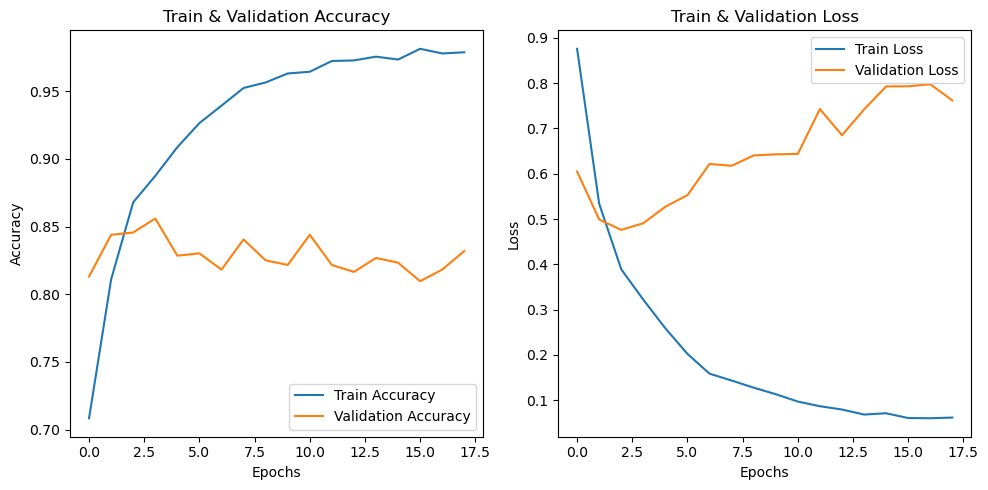

In [47]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train & Validation Loss')

plt.tight_layout()
plt.show()

# **Text**

count    4663.000000
mean      295.174137
std       257.925530
min         1.000000
25%       118.000000
50%       239.000000
75%       383.500000
max      2190.000000
Name: tweet_length, dtype: float64


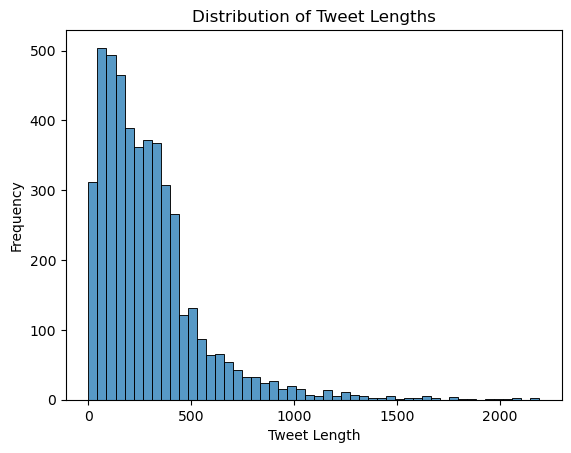

In [69]:
traindf['tweet_length'] = traindf['tweet'].apply(len)
print(traindf['tweet_length'].describe())

sns.histplot(traindf['tweet_length'], bins=50)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.show()

In [70]:
class CustomTextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tweet = str(self.data.loc[index, 'tweet'])
        label = self.data.loc[index, 'label']

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True,
            padding='max_length'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [71]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [72]:
ttrain_dataset = CustomTextDataset(traindf, tokenizer, max_length=300)
tvalid_dataset = CustomTextDataset(validdf, tokenizer, max_length=300)
ttest_dataset = CustomTextDataset(testdf, tokenizer, max_length=300)

In [73]:
batch_size=28
ttrain_loader = DataLoader(ttrain_dataset, batch_size, shuffle=True)
tvalid_loader = DataLoader(tvalid_dataset, batch_size, shuffle=False)
ttest_loader = DataLoader(ttest_dataset, batch_size, shuffle=False)

In [74]:
print(len(ttrain_loader))
print(len(tvalid_loader))
print(len(ttest_loader))

167
21
21


In [75]:
text_models=[]

In [76]:
criterion = nn.CrossEntropyLoss()
num_classes = 6
num_iters= 30000
num_epochs = num_iters / (len(ttrain_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

180


In [77]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logit = self.linear(pooled_output)
        return logit

tmodelBert = BertClassifier('bert-base-uncased', num_classes)
text_models.append(tmodelBert)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [78]:
class XLNetClassifier(nn.Module):
    def __init__(self, xlnet_model_name, num_classes):
        super(XLNetClassifier, self).__init__()
        self.xlnet = XLNetModel.from_pretrained(xlnet_model_name)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.xlnet.config.d_model, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.xlnet(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logit = self.linear(pooled_output)
        return logit

tmodelXL = XLNetClassifier('xlnet-base-cased', num_classes)
text_models.append(tmodelXL)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [79]:
text_models

[BertClassifier(
   (bert): BertModel(
     (embeddings): BertEmbeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (token_type_embeddings): Embedding(2, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): BertEncoder(
       (layer): ModuleList(
         (0-11): 12 x BertLayer(
           (attention): BertAttention(
             (self): BertSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): BertSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)
               (LayerNorm): LayerNorm((768,), eps

In [80]:
text_model_name=["bert", "xlnet"]

In [81]:
ttrain_loss_history0 = []
ttrain_acc_history0 = []
ttest_loss_history0 = []
ttest_acc_history0 = []

ttrain_loss_history1 = []
ttrain_acc_history1= []
ttest_loss_history1 = []
ttest_acc_history1 = []


In [82]:
learning_rate = 0.0001
momentum = 0.9
beta_2 = 0.999
epsilon = 1e-8
weight_decay = 0.0
amsgrad = False

In [83]:
for idx, model in enumerate(text_models):
    
    print("===============> ",text_model_name[idx], "<===================")
    model.to(device)
    optimizer = optim.AdamW(model.parameters(),
                           lr=learning_rate)

    iter= 0
    patience = 10
    best_val_loss = float('inf')
    counter = 0


    callback_list = callbacks_check()

    for epoch in range(num_epochs):
        
        model.train()   
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        for batch in ttrain_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(ttrain_loader)
        train_accuracy = correct_predictions / total_samples

        if idx==0:
            ttrain_loss_history0.append(avg_loss)
            ttrain_acc_history0.append(train_accuracy)

        else:
            ttrain_loss_history1.append(avg_loss)
            ttrain_acc_history1.append(train_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")
        
        model.eval()
        val_loss_total = 0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for batch in tvalid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                logits = model(input_ids, attention_mask)
                preds = torch.argmax(logits, dim=1)

                val_loss = criterion(logits, labels)
                val_loss_total += val_loss.item()
                
                _, val_predicted = torch.max(logits, 1)
                val_correct_predictions += (val_predicted == labels).sum().item()
                val_total_samples += labels.size(0)

        val_loss_avg = val_loss_total / len(tvalid_loader)
        val_accuracy = val_correct_predictions / val_total_samples

        if idx==0:
            ttest_loss_history0.append(val_loss_avg)
            ttest_acc_history0.append(val_accuracy)

        else:
            ttest_loss_history1.append(val_loss_avg)
            ttest_acc_history1.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if callback_list.on_epoch_end(epoch+1,train_accuracy):
            print(print("Early stopping triggered at epoch",epoch+1))
            break

        elif (val_loss_avg < best_val_loss):
            best_val_loss = val_loss_avg
            counter = 0
            torch.save(model.state_dict(),'text_{}_best_model.pt'.format(idx))
            print("Model saved")
            model.train()

        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}.')
                break
    print("-------------------------------------------------------------")

print("###################### Training Complete ########################")

===============>  bert <===================
Epoch [1/180] - Train Loss: 0.5493 - Train Accuracy: 0.8149
Epoch [1/180] - Validation Loss: 0.2465, Validation Accuracy: 0.9297
Model saved
Epoch [2/180] - Train Loss: 0.2435 - Train Accuracy: 0.9192
Epoch [2/180] - Validation Loss: 0.3023, Validation Accuracy: 0.9125
Epoch [3/180] - Train Loss: 0.2068 - Train Accuracy: 0.9374
Epoch [3/180] - Validation Loss: 0.2863, Validation Accuracy: 0.9177
Epoch [4/180] - Train Loss: 0.1461 - Train Accuracy: 0.9537
Epoch [4/180] - Validation Loss: 0.3006, Validation Accuracy: 0.9074
Epoch [5/180] - Train Loss: 0.1502 - Train Accuracy: 0.9515
Epoch [5/180] - Validation Loss: 0.3657, Validation Accuracy: 0.8919
Epoch [6/180] - Train Loss: 0.1005 - Train Accuracy: 0.9708
Epoch [6/180] - Validation Loss: 0.4060, Validation Accuracy: 0.9091
Epoch [7/180] - Train Loss: 0.0832 - Train Accuracy: 0.9783
Epoch [7/180] - Validation Loss: 0.4072, Validation Accuracy: 0.9125
Epoch [8/180] - Train Loss: 0.0780 - Trai

In [84]:
textMaxlist=[max(ttest_acc_history0),max(ttest_acc_history1)]
tbm=textMaxlist.index(max(textMaxlist))
tbm

0

In [85]:
ttrain_loss_history = []
ttrain_acc_history = []
ttest_loss_history = []
ttest_acc_history = []

In [86]:
model = text_models[tbm]
model.to(device)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [87]:
if tbm==0:

    model.load_state_dict(torch.load('text_0_best_model.pt'))
    print("Bert Model Loaded")

    ttrain_acc_history= ttrain_acc_history0
    ttest_acc_history= ttest_acc_history0

    ttrain_loss_history= ttrain_loss_history0
    ttest_loss_history= ttest_loss_history0

elif bm==1:

    model.load_state_dict(torch.load('text_1_best_model.pt'))
    print("XLNet Model Loaded")

    ttrain_acc_history= ttrain_acc_history1
    ttest_acc_history= ttest_acc_history1

    ttrain_loss_history= ttrain_loss_history1
    ttest_loss_history= ttest_loss_history1

Bert Model Loaded


In [97]:
TextModel= model
model.eval()
test_labels = []
test_preds = []

with torch.no_grad():
    for batch in ttest_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)

        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

In [98]:
true_labels = np.array(test_labels)
predicted_labels = np.array(test_preds)

In [100]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluation Metrics:
Accuracy: 0.9024
Precision: 0.9034
Recall: 0.9024
F1 Score: 0.9019


In [101]:
target_names = ['non_damage', 'damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage']
report = classification_report(true_labels, predicted_labels, target_names=target_names)

print("Classification Report:")
print(report)

Classification Report:
                        precision    recall  f1-score   support

            non_damage       0.97      0.99      0.98       291
damaged_infrastructure       0.86      0.88      0.87       144
        damaged_nature       0.87      0.71      0.78        55
                 fires       0.83      0.78      0.81        37
                 flood       0.66      0.75      0.70        36
          human_damage       0.90      0.86      0.88        21

              accuracy                           0.90       584
             macro avg       0.85      0.83      0.84       584
          weighted avg       0.90      0.90      0.90       584



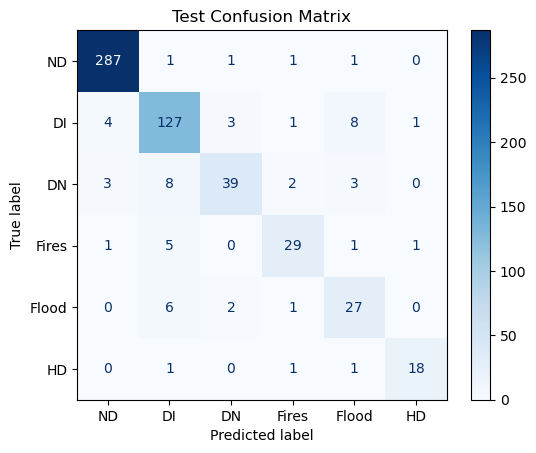

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels= ['ND','DI','DN','Fires','Flood','HD']
test_confusion = confusion_matrix(true_labels, predicted_labels)
test_confusion_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion, display_labels=class_labels)
test_confusion_display.plot(cmap=plt.cm.Blues)
plt.title('Test Confusion Matrix')
plt.show()

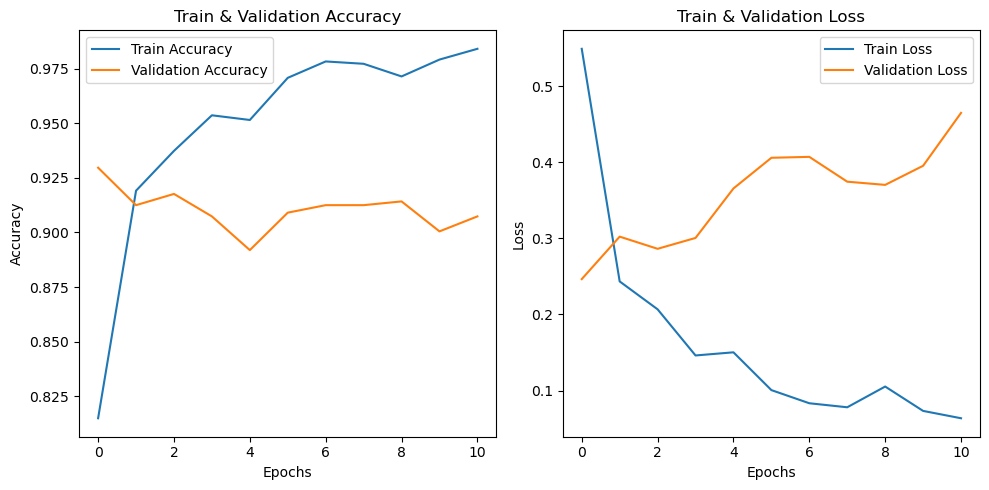

In [103]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(ttrain_acc_history, label='Train Accuracy')
plt.plot(ttest_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ttrain_loss_history, label='Train Loss')
plt.plot(ttest_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train & Validation Loss')

plt.tight_layout()
plt.show()